# Covid-19 Monitoring Notebook 
The Johns Hopkins Center for Systems Science and Engineering (CSSE) operates a [dashboard](https://systems.jhu.edu/research/public-health/ncov/) on the Web to follow the covid-19 cases and deaths all over the world. The data is collected on a daily basis from different sources and has been made available on [Github](https://github.com/CSSEGISandData/COVID-19). This is a selection for some European countries. The observed cases are shown for each country and then merged together for comparison.

[Italy](#Italy)  
[Germany](#Germany)  
[France](#France)  
[Spain](#Spain)  
[Comparisons](#Comparisons)  
[Summary](#Summary)

***
## Definitions
We follow the definitions for measures as given in the book by Bonita et al., [Basic Epidemiology, 2nd ed.](https://apps.who.int/iris/handle/10665/43541) available in different languages from the World Health Organization website. 

***Confirmed Case*** according to the European Centre for Disease Prevention and Control, a person with laboratory confirmation of virus causing COVID-19 infection, irrespective of clinical signs and symptoms.

***Cumulative Incidence*** is the number of new cases of the disease during a specified period of time in a specific healthy population. It represents the risk of becoming ill. In this notebook the period of time considered is from the onset of the disease  up to the last update report and the population at risk is the entire population of a country. The cumulative incidence is computed as the ratio between the cumulative confirmed infections and the country's population, assuming that a vast majority is still healthy, per 100.000 people (see Bonita et al., p.21). If, at any given time point t, C(t) denotes the cumulative confirmed infections and P(t) denotes the population at risk, that we assume for the time being to be the entire population of a country, the cumulative incidence CI(t) is

$$CI(t) = \frac{C(t)}{P(t)}\times100.000$$

***Case Fatality*** represents the ratio between the number of people who have died from the infection and the number of people who have been confirmed to be infected, expressed as a percentage. In this notebook it is computed as the ratio between the cumulative deaths and the cumulative confirmed infections (see Bonita et al., p.22). If, at any given time point t, C(t) denotes the cumulative confirmed infections, as before, and D(t) denotes the cumulative number of deaths, the case fatality CF(t) is 

$$CF(t) = \frac{D(t)}{C(t)}\times100$$

This is a crude estimation of the case fatality that does not take into account the time delay that occurs between the confirmation of an infection and its outcome, being a recovery or a death.  

***Doubling Time*** is the time it takes for a parameter to double in value. In this notebook it is computed for the cumulative confirmed infections by finding the day, before the last one, in which the value was a half. The longer time it takes for the number of infections to double, and the higher is the value of the doubling time, the better.  

***Basic Reproduction Number $R_0$*** is the expected number of secondary cases generated by one infected individual in a population where all individuals are susceptibles, i.e. no one is immunized because of recovery or vaccination. According to the [Susceptible-Infectious-Recovered](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) (SIR) deterministic model, it is possible to predict the number of infections $I(t)$ over the time $t$, at the early stage of an outbreak, using the equation  

$$I(t) = I_0\exp^{\frac{R_0 - 1}{d} t}$$

where $d$ represents the average duration of the infection for an individual. From this equation it can be seen that, if $R_0 > 1$ there will be an epidemic outbreak. A rough estimation of $R_0$ can be computed using the doubling time $\Delta t_2$ such that  


$$\frac{I(t)}{I_0} = \exp^{\frac{R_0 - 1}{d} \Delta t_2} = 2$$


taking the logarithm of both sides we have

$$\frac{R_0 - 1}{d} \Delta t_2 = log(2)$$


and finally 

$$ R_0 = log(2) \frac{d}{\Delta t_2} + 1$$

Assuming a duration of the infection of, e.g. $d = 30$ days from the onset, few days before the symptoms appear till complete recovery, and computing the doubling time from the data of confirmed infections, as soon as they are available, we can get a rough estimation of $R_0$. The basic reproduction number $R_0$ can be used to estimate if and how quickly an infection can spread in a population. Since in the SIR model $R_0$ depends on the rate of contacts that people have, it is clear that social distance is an important action to prevent the spread of the infection, if enacted at its onset. One limitation of $R_0$, computed from the confirmed infection, is that it can underestimate its real value since the majority of the cases are individuals who had only mild or even no symptoms at all.


## References

* [Report of the WHO-China Joint Mission on Coronavirus Disease 2019 (COVID-19)](https://www.who.int/docs/default-source/coronaviruse/who-china-joint-mission-on-covid-19-final-report.pdf)
* [Riou et al. - Adjusted age-specific case fatality ratio during the COVID-19 epidemic in Hubei, China, January and February 2020](https://www.medrxiv.org/content/10.1101/2020.03.04.20031104v1)
* [Russell et al. - Using a delay-adjusted case fatality ratio to estimate under-reporting](https://cmmid.github.io/topics/covid19/severity/global_cfr_estimates.html) 
* [Verity et al. - Estimates of severity of COVID-19 disease](https://www.medrxiv.org/content/10.1101/2020.03.09.20033357v1)
* [Wu et al. - Nowcasting and forecasting the potential domestic and international spread of the 2019-nCoV outbreak originating in Wuhan, China: a modelling study](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20);30260-9/fulltext)
* [Liu et al. - Measurability of the epidemic reproduction number in data-driven contact networks](https://www.ncbi.nlm.nih.gov/pubmed/30463945)

## Software 
This notebook uses python as programming language, and some libraries, pandas for data handling and matplotlib for data visualization. The covid-19 data is handled as pandas time series and is visualized as simple line plot with the dates as x dimension and the observation as y dimension. Bar charts cannot use directly pandas' time series objects so two separated arrays are created from the time series to be used as input for bar charts, days and observations. The solution used may change if better libraries are discovered.

<a href="https://colab.research.google.com/github/luigiselmi/datascience/blob/master/python/covid19-monitoring-notebook.ipynb" target="_blank"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" width="117" height="20"></a>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime
import seaborn as sns; sns.set()
import warnings
#warnings.filterwarnings('ignore')
from platform import python_version
print("python version: %s"%python_version())
print("numpy version: %s"%np.__version__)
print("pandas version: %s"%pd.__version__)

python version: 3.7.4
numpy version: 1.16.5
pandas version: 0.25.1


### Functions
A collection of functions that are not directly available in the python libraries.

In [2]:
def doubling_time(timeseries):
    """Computes the number of days for the values to double since the last day"""
    dt = pd.Series(index = timeseries.index)
    for last_day in timeseries.sort_index(ascending=False).index.strftime('%Y-%m-%d'): 
        for d in timeseries.sort_index(ascending=False).index: # sorts the dates in descending order
            if timeseries[last_day] - timeseries[d] * 2 >= 0:
                dt[last_day] = (pd.to_datetime(last_day) - d).days 
                break
    return dt.fillna(0).astype('int32')

### Data Structures

In [3]:
countries = ['Italy', 'Germany', 'France', 'Spain']
summary = pd.DataFrame(columns = ['Confirmed Infections', 'Doubling Time', 'Incidence', 'Deaths', 'Case Fatality'], 
                       index = countries)

***
## Data sources

### Johns Hopkins CSSE - Covid-19 Epidemiological data 

In [4]:
#url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
confirmed_dataset = pd.read_csv(url_confirmed) 
#url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv"
url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
deaths_dataset = pd.read_csv(url_deaths)
# creates an index of dates
start_date_index = 14 # starts from February 1st
dates_array = [date for date in confirmed_dataset.columns[start_date_index:]] # removes first columns that are not dates
dates_index = pd.to_datetime(dates_array)
last_day = dates_index[dates_index.size - 1].strftime('%Y-%m-%d')

### Eurostat population data

In [5]:
url_population = "https://raw.githubusercontent.com/luigiselmi/datascience/master/data/eurostat_population_by_age_2019.csv"
population = pd.read_csv(url_population)

### Eurostat health care facilities
Number of available beds (2017)

In [6]:
url_beds = "https://raw.githubusercontent.com/luigiselmi/datascience/master/data/eurostat_hlth_rs_bds.csv"
beds = pd.read_csv(url_beds)

***
## Italy

In [7]:
population_it = population[population['country_code'] == 'IT']['total'].values[0]
print("Italy's population (2019) = %d"%population_it)

Italy's population (2019) = 60359546


In [8]:
beds_it = beds[beds['country_code'] == 'IT']['2017'].values[0]
print("Italy's public and private health care facilities, available beds in 2017 = %d"%beds_it)

Italy's public and private health care facilities, available beds in 2017 = 192548


In [9]:
people_per_bed_it =  population_it / beds_it 
print("Number of persons per bed = %.0f"%people_per_bed_it)

Number of persons per bed = 313


### Cumulative confirmed infections
The number of infected individuals each day is the sum of all the confirmed infected individuals from the beginning up to that day.

In [10]:
confirmed_dataset_it = confirmed_dataset[confirmed_dataset['Country/Region'] == 'Italy']
confirmed_dataset_values_it = [confirmed for confirmed in confirmed_dataset_it.values[0][start_date_index:]] 
confirmed_infections_it = pd.Series(confirmed_dataset_values_it, index=dates_index)
confirmed_infections_it['2020-03-15':]

2020-03-15     24747
2020-03-16     27980
2020-03-17     31506
2020-03-18     35713
2020-03-19     41035
2020-03-20     47021
2020-03-21     53578
2020-03-22     59138
2020-03-23     63927
2020-03-24     69176
2020-03-25     74386
2020-03-26     80589
2020-03-27     86498
2020-03-28     92472
2020-03-29     97689
2020-03-30    101739
2020-03-31    105792
2020-04-01    110574
2020-04-02    115242
2020-04-03    119827
2020-04-04    124632
2020-04-05    128948
dtype: int64

### Confirmed infections per day
The confirmed infections per day are computed from the cumulative confirmed infections by computing the difference between two consecutive days.

In [11]:
confirmed_per_day_array_it = [confirmed_infections_it[d++1] - confirmed_infections_it[d] for d in range(dates_index.size - 1)]
confirmed_per_day_it = pd.Series(confirmed_per_day_array_it, index=dates_index[1:])
confirmed_per_day_it['2020-03-15':]

2020-03-15    3590
2020-03-16    3233
2020-03-17    3526
2020-03-18    4207
2020-03-19    5322
2020-03-20    5986
2020-03-21    6557
2020-03-22    5560
2020-03-23    4789
2020-03-24    5249
2020-03-25    5210
2020-03-26    6203
2020-03-27    5909
2020-03-28    5974
2020-03-29    5217
2020-03-30    4050
2020-03-31    4053
2020-04-01    4782
2020-04-02    4668
2020-04-03    4585
2020-04-04    4805
2020-04-05    4316
dtype: int64

<BarContainer object of 64 artists>

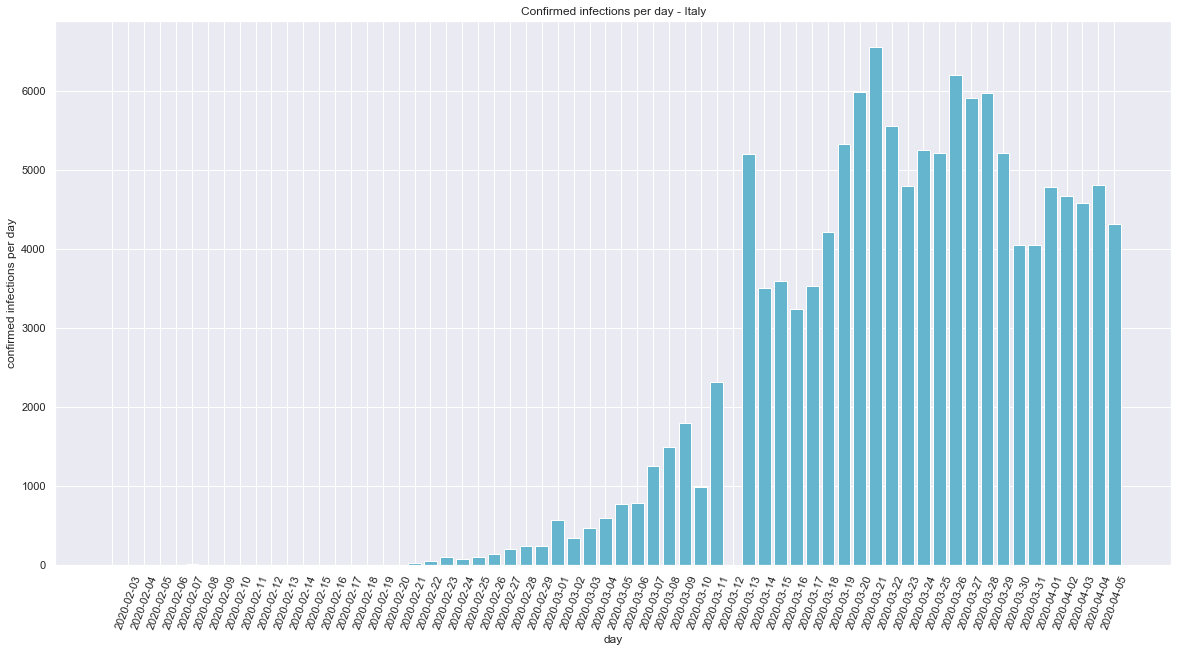

In [13]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Confirmed infections per day - Italy")
ax.set_xlabel("day")
ax.set_ylabel("confirmed infections per day");
ax.set_xticks(confirmed_per_day_it.index)
ax.set_xticklabels(confirmed_per_day_it.index[1:].format('%Y-%m-%d'), rotation=70)
plt.bar(dates_array[1:], confirmed_per_day_array_it, color='c')

### Cumulative deaths
The number of deaths each day is the sum of the deaths from the beginning up to that day.

In [14]:
deaths_dataset_it = deaths_dataset[deaths_dataset['Country/Region'] == 'Italy']
deaths_dataset_values_it = [death for death in deaths_dataset_it.values[0][start_date_index:]]
deaths_it = pd.Series(deaths_dataset_values_it, index=dates_index)
deaths_it['2020-03-15':]

2020-03-15     1809
2020-03-16     2158
2020-03-17     2503
2020-03-18     2978
2020-03-19     3405
2020-03-20     4032
2020-03-21     4825
2020-03-22     5476
2020-03-23     6077
2020-03-24     6820
2020-03-25     7503
2020-03-26     8215
2020-03-27     9134
2020-03-28    10023
2020-03-29    10779
2020-03-30    11591
2020-03-31    12428
2020-04-01    13155
2020-04-02    13915
2020-04-03    14681
2020-04-04    15362
2020-04-05    15887
dtype: int64

### Deaths per day
The deaths per day are computed from the cumulative deaths by computing the difference between two consecutive days.

In [15]:
deaths_per_day_array_it = [deaths_it[d++1] - deaths_it[d] for d in range(dates_index.size - 1)]
deaths_per_day_it = pd.Series(deaths_per_day_array_it, index=dates_index[1:])
deaths_per_day_it['2020-03-15':]

2020-03-15    368
2020-03-16    349
2020-03-17    345
2020-03-18    475
2020-03-19    427
2020-03-20    627
2020-03-21    793
2020-03-22    651
2020-03-23    601
2020-03-24    743
2020-03-25    683
2020-03-26    712
2020-03-27    919
2020-03-28    889
2020-03-29    756
2020-03-30    812
2020-03-31    837
2020-04-01    727
2020-04-02    760
2020-04-03    766
2020-04-04    681
2020-04-05    525
dtype: int64

<BarContainer object of 64 artists>

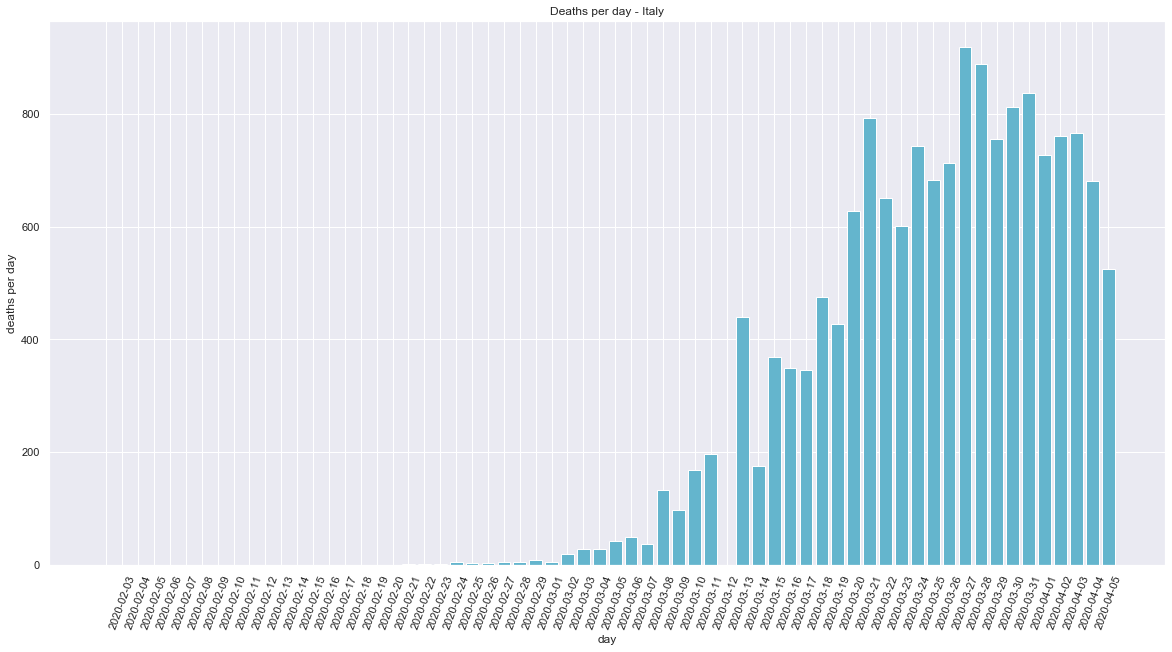

In [16]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Deaths per day - Italy")
ax.set_xlabel("day")
ax.set_ylabel("deaths per day");
ax.set_xticks(deaths_per_day_it.index)
ax.set_xticklabels(deaths_per_day_it.index[1:].format('%Y-%m-%d'), rotation=70)
plt.bar(dates_array[1:], deaths_per_day_array_it, color='c')

### Cumulative confirmed infections doubling time
Number of days for the cumulative confirmed infections to double

In [17]:
doubling_time_it = doubling_time(confirmed_infections_it)[last_day]
summary['Doubling Time']['Italy'] = doubling_time(confirmed_infections_it)[last_day]
print("Italy's cumulative infections doubling time = %.0d days"%doubling_time_it)

Italy's cumulative infections doubling time = 13 days


### Cumulative incidence

In [18]:
cumulative_incidence_it = (confirmed_infections_it[confirmed_infections_it.size - 1] / population_it) * 100000
summary['Incidence']['Italy'] = round((confirmed_infections_it[confirmed_infections_it.size - 1] / population_it) * 100000)
print("Italy's cumulative incidence = %.0f per 100.000 persons"%cumulative_incidence_it)

Italy's cumulative incidence = 214 per 100.000 persons


### Case fatality

In [19]:
last_infections_it = confirmed_infections_it[confirmed_infections_it.size - 1]
last_deaths_it = deaths_it[deaths_it.size - 1]
last_case_fatality_it = (last_deaths_it / last_infections_it) * 100
summary['Confirmed Infections']['Italy'] = confirmed_infections_it[confirmed_infections_it.size - 1]
summary['Deaths']['Italy'] = deaths_it[deaths_it.size - 1]
summary['Case Fatality']['Italy'] = round((deaths_it[deaths_it.size - 1] / confirmed_infections_it[confirmed_infections_it.size - 1]) * 100,1)
print("Last report day: {0:4s} \ndeaths: {1:5d}; cumulative confirmed infections: {2:5d}; case fatality {3:5.2f} %".format(last_day, last_deaths_it, last_infections_it, last_case_fatality_it))  

Last report day: 2020-04-05 
deaths: 15887; cumulative confirmed infections: 128948; case fatality 12.32 %


In [20]:
cf_array_it = [(deaths_it[d] / confirmed_infections_it[d]) * 100 for d in range(dates_index.size)]
cf_it = pd.Series(cf_array_it, index=dates_index)

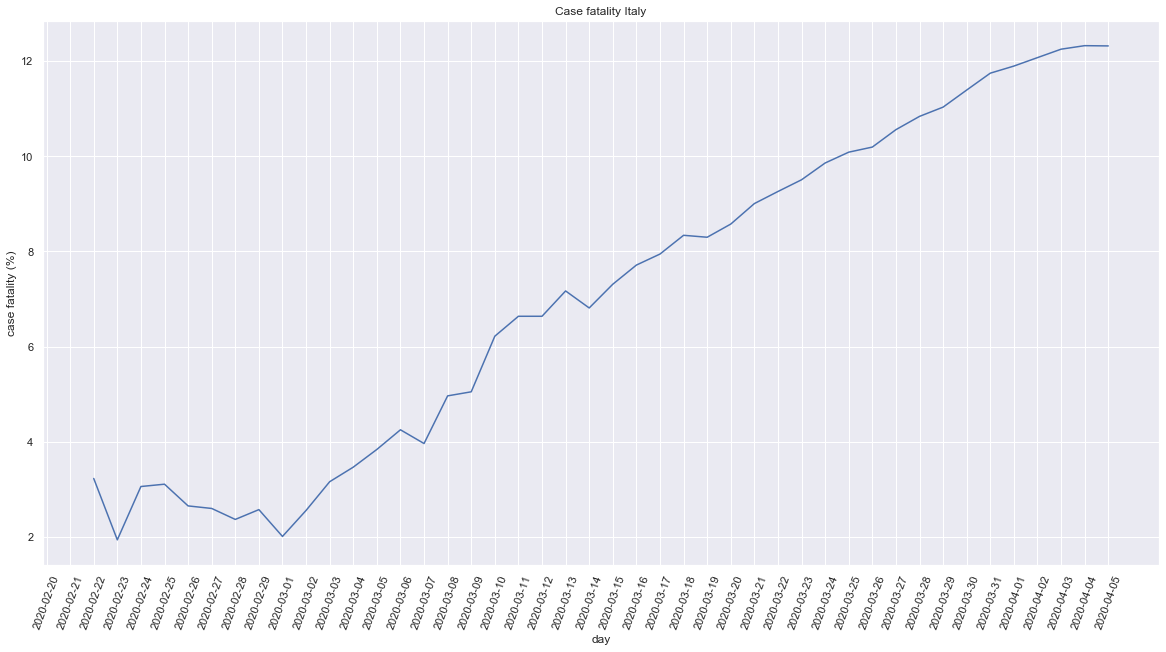

In [21]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Case fatality Italy")
ax.set_xlabel("day")
ax.set_ylabel("case fatality (%)");
ax.set_xticks(cf_it.index)
ax.set_xticklabels(cf_it.index[1:].format('%Y-%m-%d'), rotation=70)
plt.plot(cf_it['2020-02-22':])

***
## Germany

In [22]:
population_de = population[population['country_code'] == 'DE']['total'].values[0]
print("Germany's population (2019) = %d"%population_de)

Germany's population (2019) = 83019213


In [23]:
beds_de = beds[beds['country_code'] == 'DE']['2017'].values[0]
print("Germany's public and private health care facilities, available beds in 2017 = %d"%beds_de)

Germany's public and private health care facilities, available beds in 2017 = 661448


In [24]:
people_per_bed_de =  population_de / beds_de 
print("Number of persons per bed = %.0f"%people_per_bed_de)

Number of persons per bed = 126


### Cumulative confirmed infections
The number of infected individuals each day is the sum of all the confirmed infected individuals from the beginning up to that day.

In [25]:
confirmed_dataset_de = confirmed_dataset[confirmed_dataset['Country/Region'] == 'Germany'] 
confirmed_dataset_values_de = [confirmed for confirmed in confirmed_dataset_de.values[0][start_date_index:]] 
confirmed_infections_de = pd.Series(confirmed_dataset_values_de, index=dates_index)
confirmed_infections_de['2020-03-15':] 

2020-03-15      5795
2020-03-16      7272
2020-03-17      9257
2020-03-18     12327
2020-03-19     15320
2020-03-20     19848
2020-03-21     22213
2020-03-22     24873
2020-03-23     29056
2020-03-24     32986
2020-03-25     37323
2020-03-26     43938
2020-03-27     50871
2020-03-28     57695
2020-03-29     62095
2020-03-30     66885
2020-03-31     71808
2020-04-01     77872
2020-04-02     84794
2020-04-03     91159
2020-04-04     96092
2020-04-05    100123
dtype: int64

### Confirmed infections per day
The confirmed infections per day are computed from the cumulative confirmed infections by computing the difference between two consecutive days.

In [26]:
confirmed_per_day_array_de = [confirmed_infections_de[d++1] - confirmed_infections_de[d] for d in range(dates_index.size - 1)]
confirmed_per_day_de = pd.Series(confirmed_per_day_array_de, index=dates_index[1:])
confirmed_per_day_de['2020-03-15':]

2020-03-15    1210
2020-03-16    1477
2020-03-17    1985
2020-03-18    3070
2020-03-19    2993
2020-03-20    4528
2020-03-21    2365
2020-03-22    2660
2020-03-23    4183
2020-03-24    3930
2020-03-25    4337
2020-03-26    6615
2020-03-27    6933
2020-03-28    6824
2020-03-29    4400
2020-03-30    4790
2020-03-31    4923
2020-04-01    6064
2020-04-02    6922
2020-04-03    6365
2020-04-04    4933
2020-04-05    4031
dtype: int64

<BarContainer object of 64 artists>

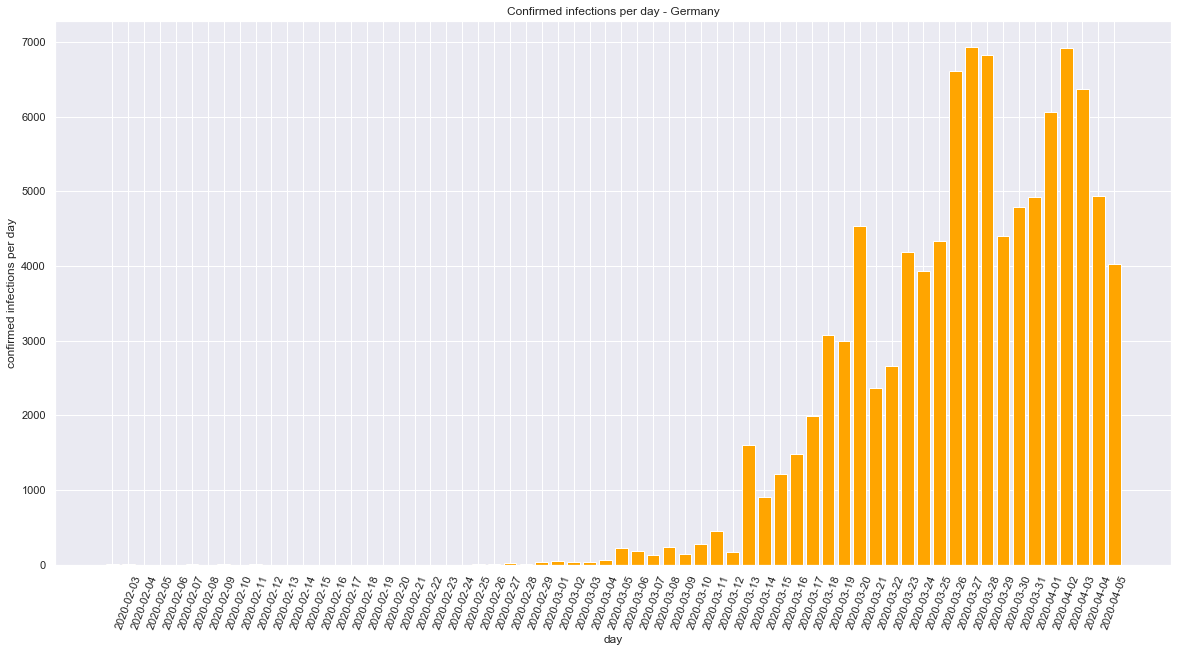

In [27]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Confirmed infections per day - Germany")
ax.set_xlabel("day")
ax.set_ylabel("confirmed infections per day");
ax.set_xticks(confirmed_per_day_de.index)
ax.set_xticklabels(confirmed_per_day_de.index[1:].format('%Y-%m-%d'), rotation=70)
plt.bar(dates_array[1:], confirmed_per_day_array_de, color='orange')

### Cumulative deaths
The number of deaths each day is the sum of the deaths from the beginning up to that day.

In [28]:
deaths_dataset_de = deaths_dataset[deaths_dataset['Country/Region'] == 'Germany']
deaths_dataset_values_de = [death for death in deaths_dataset_de.values[0][start_date_index:]]
deaths_de = pd.Series(deaths_dataset_values_de, index=dates_index)
deaths_de['2020-03-15':]

2020-03-15      11
2020-03-16      17
2020-03-17      24
2020-03-18      28
2020-03-19      44
2020-03-20      67
2020-03-21      84
2020-03-22      94
2020-03-23     123
2020-03-24     157
2020-03-25     206
2020-03-26     267
2020-03-27     342
2020-03-28     433
2020-03-29     533
2020-03-30     645
2020-03-31     775
2020-04-01     920
2020-04-02    1107
2020-04-03    1275
2020-04-04    1444
2020-04-05    1584
dtype: int64

### Deaths per day
The deaths per day are computed from the cumulative deaths by computing the difference between two consecutive days.

In [29]:
deaths_per_day_array_de = [deaths_de[d++1] - deaths_de[d] for d in range(dates_index.size - 1)]
deaths_per_day_de = pd.Series(deaths_per_day_array_de, index=dates_index[1:])
deaths_per_day_de['2020-03-15':]

2020-03-15      2
2020-03-16      6
2020-03-17      7
2020-03-18      4
2020-03-19     16
2020-03-20     23
2020-03-21     17
2020-03-22     10
2020-03-23     29
2020-03-24     34
2020-03-25     49
2020-03-26     61
2020-03-27     75
2020-03-28     91
2020-03-29    100
2020-03-30    112
2020-03-31    130
2020-04-01    145
2020-04-02    187
2020-04-03    168
2020-04-04    169
2020-04-05    140
dtype: int64

<BarContainer object of 64 artists>

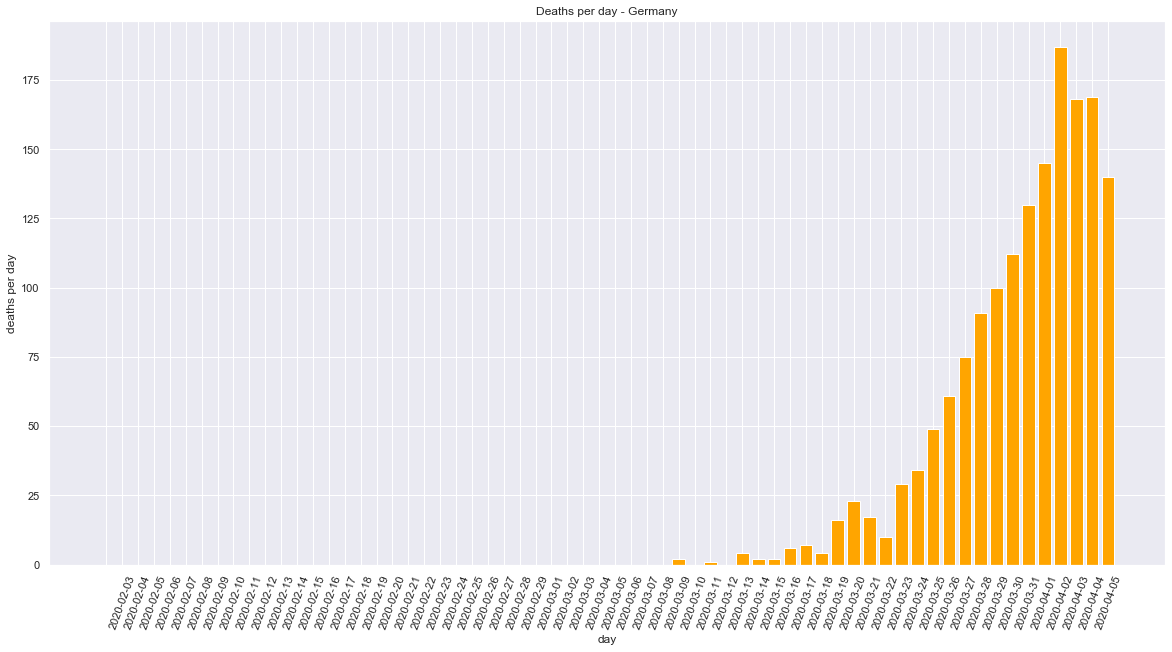

In [30]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Deaths per day - Germany")
ax.set_xlabel("day")
ax.set_ylabel("deaths per day");
ax.set_xticks(deaths_per_day_de.index)
ax.set_xticklabels(deaths_per_day_de.index[1:].format('%Y-%m-%d'), rotation=70)
plt.bar(dates_array[1:], deaths_per_day_array_de, color='orange')

### Cumulative confirmed infections doubling time
Number of days for the cumulative confirmed infections to double

In [31]:
doubling_time_de = doubling_time(confirmed_infections_de)[last_day]
summary['Doubling Time']['Germany'] = doubling_time(confirmed_infections_de)[last_day]
print("Germany's cumulative infections doubling time = %.0d days"%doubling_time_de)

Germany's cumulative infections doubling time = 10 days


### Cumulative incidence

In [32]:
cumulative_incidence_de = (confirmed_infections_de[confirmed_infections_de.size - 1] / population_de) * 100000
summary['Incidence']['Germany'] = round((confirmed_infections_de[confirmed_infections_de.size - 1] / population_de) * 100000)
print("Germany's cumulative incidence = %.0f per 100.000 persons"%cumulative_incidence_de)

Germany's cumulative incidence = 121 per 100.000 persons


### Case fatality

In [33]:
last_infections_de = confirmed_infections_de[confirmed_infections_de.size - 1]
last_deaths_de = deaths_de[deaths_de.size - 1]
last_case_fatality_de = (last_deaths_de / last_infections_de) * 100 
summary['Confirmed Infections']['Germany'] = confirmed_infections_de[confirmed_infections_de.size - 1]
summary['Deaths']['Germany'] = deaths_de[deaths_de.size - 1]
summary['Case Fatality']['Germany'] = round((deaths_de[deaths_de.size - 1] / confirmed_infections_de[confirmed_infections_de.size - 1]) * 100,1)
print("Last report day: {0:4s} \ndeaths: {1:5d}; cumulative confirmed infections: {2:5d}; case fatality {3:5.2f} %".format(last_day, last_deaths_de, last_infections_de, last_case_fatality_de))  

Last report day: 2020-04-05 
deaths:  1584; cumulative confirmed infections: 100123; case fatality  1.58 %


In [34]:
cf_array_de = [(deaths_de[d] / confirmed_infections_de[d]) * 100 for d in range(dates_index.size)]
cf_de = pd.Series(cf_array_de, index=dates_index)

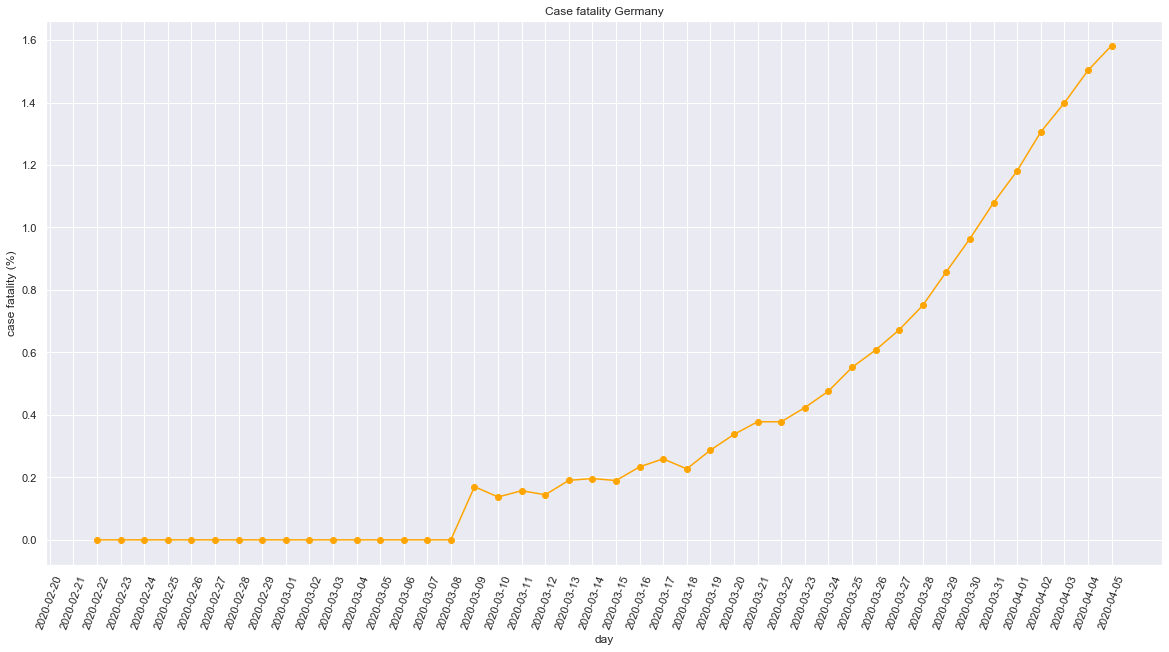

In [35]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Case fatality Germany")
ax.set_xlabel("day")
ax.set_ylabel("case fatality (%)");
ax.set_xticks(cf_de.index)
ax.set_xticklabels(cf_de.index[1:].format('%Y-%m-%d'), rotation=70)
plt.plot(cf_de['2020-02-22':], color='orange', marker='o')

***
## France

In [36]:
population_fr = population[population['country_code'] == 'FR']['total'].values[0]
print("France's population (2019) = %d"%population_fr)

France's population (2019) = 67012883


In [37]:
beds_fr = beds[beds['country_code'] == 'FR']['2017'].values[0]
print("France's public and private health care facilities, available beds in 2017 = %d"%beds_fr)

France's public and private health care facilities, available beds in 2017 = 399865


In [38]:
people_per_bed_fr =  population_fr / beds_fr 
print("Number of persons per bed = %.0f"%people_per_bed_fr)

Number of persons per bed = 168


### Cumulative confirmed infections
The number of infected individuals each day is the sum of all the confirmed infected individuals from the beginning up to that day.

In [39]:
confirmed_dataset_fr = confirmed_dataset[confirmed_dataset['Country/Region'] == 'France']
row_france = 9
confirmed_dataset_values_fr = [confirmed for confirmed in confirmed_dataset_fr.values[row_france][start_date_index:]] 
confirmed_infections_fr = pd.Series(confirmed_dataset_values_fr, index=dates_index)
confirmed_infections_fr['2020-03-15':] 

2020-03-15     4499
2020-03-16     6633
2020-03-17     7652
2020-03-18     9043
2020-03-19    10871
2020-03-20    12612
2020-03-21    14282
2020-03-22    16018
2020-03-23    19856
2020-03-24    22304
2020-03-25    25233
2020-03-26    29155
2020-03-27    32964
2020-03-28    37575
2020-03-29    40174
2020-03-30    44550
2020-03-31    52128
2020-04-01    56989
2020-04-02    59105
2020-04-03    64338
2020-04-04    89953
2020-04-05    92839
dtype: int64

### Confirmed infections per day
The confirmed infections per day are computed from the cumulative confirmed infections by computing the difference between two consecutive days.

In [40]:
confirmed_per_day_array_fr = [confirmed_infections_fr[d++1] - confirmed_infections_fr[d] for d in range(dates_index.size - 1)]
confirmed_per_day_fr = pd.Series(confirmed_per_day_array_fr, index=dates_index[1:])
confirmed_per_day_fr['2020-03-15':]

2020-03-15       30
2020-03-16     2134
2020-03-17     1019
2020-03-18     1391
2020-03-19     1828
2020-03-20     1741
2020-03-21     1670
2020-03-22     1736
2020-03-23     3838
2020-03-24     2448
2020-03-25     2929
2020-03-26     3922
2020-03-27     3809
2020-03-28     4611
2020-03-29     2599
2020-03-30     4376
2020-03-31     7578
2020-04-01     4861
2020-04-02     2116
2020-04-03     5233
2020-04-04    25615
2020-04-05     2886
dtype: int64

<BarContainer object of 64 artists>

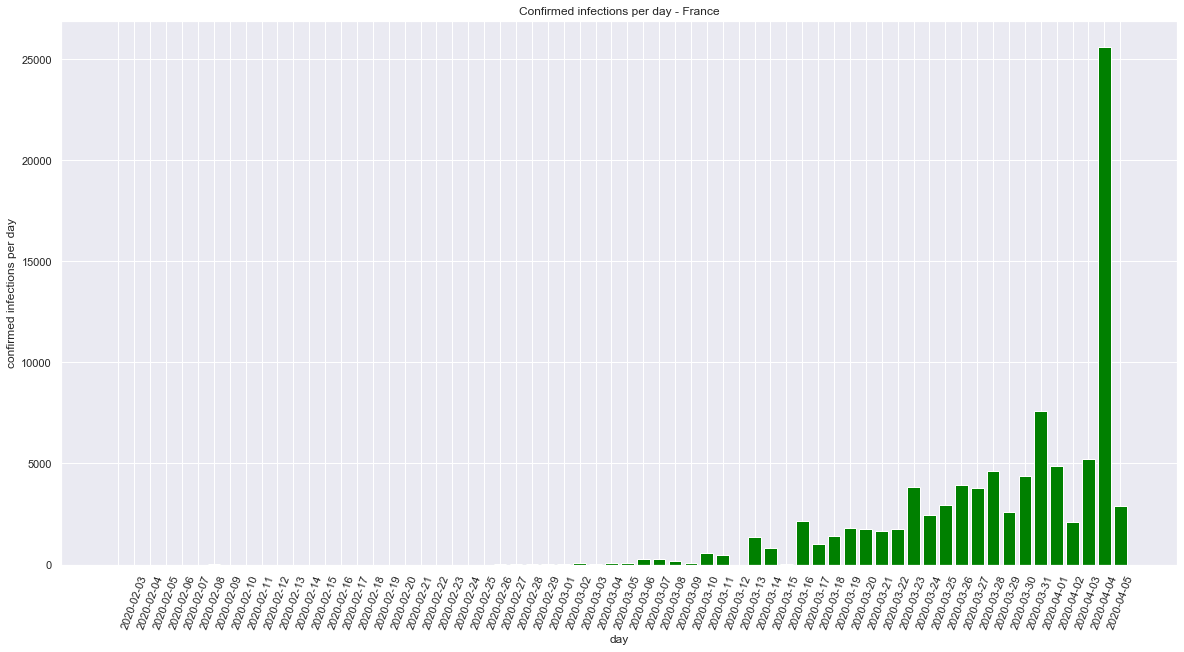

In [41]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Confirmed infections per day - France")
ax.set_xlabel("day")
ax.set_ylabel("confirmed infections per day");
ax.set_xticks(confirmed_per_day_fr.index)
ax.set_xticklabels(confirmed_per_day_fr.index[1:].format('%Y-%m-%d'), rotation=70)
plt.bar(dates_array[1:], confirmed_per_day_array_fr, color='green')

### Cumulative deaths
The number of deaths each day is the sum of the deaths from the beginning up to that day.

In [42]:
deaths_dataset_fr = deaths_dataset[deaths_dataset['Country/Region'] == 'France']
deaths_dataset_values_fr = [death for death in deaths_dataset_fr.values[row_france][start_date_index:]]
deaths_fr = pd.Series(deaths_dataset_values_fr, index=dates_index)
deaths_fr['2020-03-15':]

2020-03-15      91
2020-03-16     148
2020-03-17     148
2020-03-18     148
2020-03-19     243
2020-03-20     450
2020-03-21     562
2020-03-22     674
2020-03-23     860
2020-03-24    1100
2020-03-25    1331
2020-03-26    1696
2020-03-27    1995
2020-03-28    2314
2020-03-29    2606
2020-03-30    3024
2020-03-31    3523
2020-04-01    4032
2020-04-02    5387
2020-04-03    6507
2020-04-04    7560
2020-04-05    8078
dtype: int64

### Deaths per day
The deaths per day are computed from the cumulative deaths by computing the difference between two consecutive days.

In [43]:
deaths_per_day_array_fr = [deaths_fr[d++1] - deaths_fr[d] for d in range(dates_index.size - 1)]
deaths_per_day_fr = pd.Series(deaths_per_day_array_fr, index=dates_index[1:])
deaths_per_day_fr['2020-03-15':]

2020-03-15       0
2020-03-16      57
2020-03-17       0
2020-03-18       0
2020-03-19      95
2020-03-20     207
2020-03-21     112
2020-03-22     112
2020-03-23     186
2020-03-24     240
2020-03-25     231
2020-03-26     365
2020-03-27     299
2020-03-28     319
2020-03-29     292
2020-03-30     418
2020-03-31     499
2020-04-01     509
2020-04-02    1355
2020-04-03    1120
2020-04-04    1053
2020-04-05     518
dtype: int64

<BarContainer object of 64 artists>

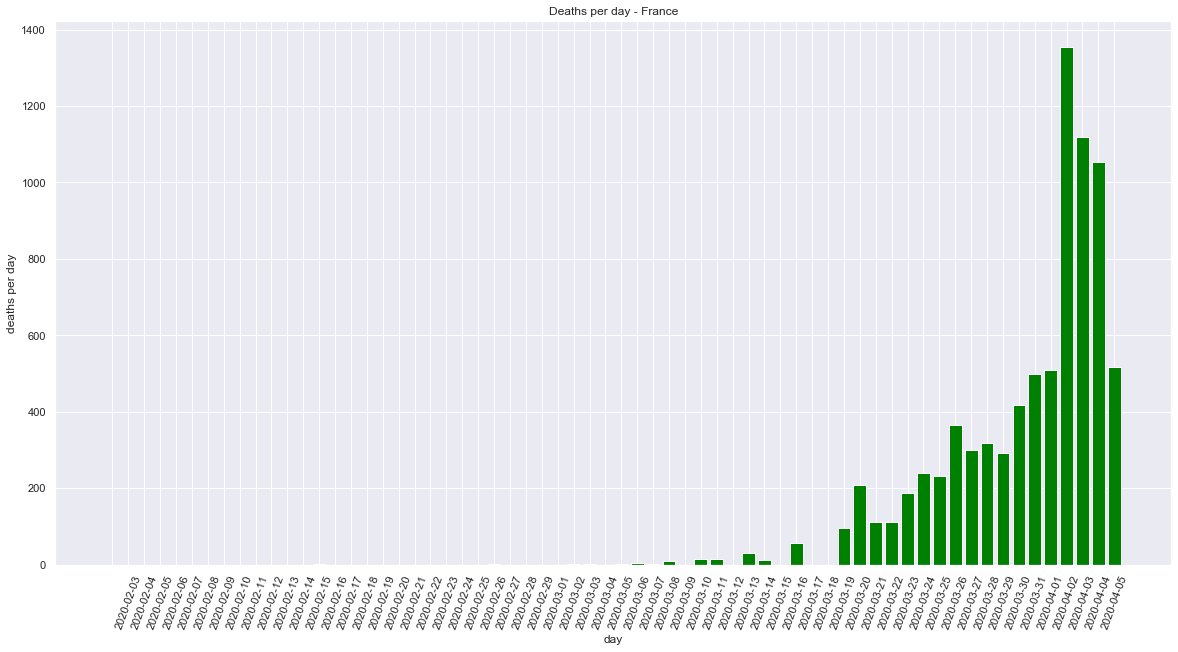

In [44]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Deaths per day - France")
ax.set_xlabel("day")
ax.set_ylabel("deaths per day");
ax.set_xticks(deaths_per_day_fr.index)
ax.set_xticklabels(deaths_per_day_fr.index[1:].format('%Y-%m-%d'), rotation=70)
plt.bar(dates_array[1:], deaths_per_day_array_fr, color='green')

### Cumulative confirmed infections doubling time
Number of days for the cumulative confirmed infections to double

In [45]:
doubling_time_fr = doubling_time(confirmed_infections_fr)[last_day]
summary['Doubling Time']['France'] = doubling_time(confirmed_infections_fr)[last_day]
print("France's cumulative infections doubling time = %.0d days"%doubling_time_fr)

France's cumulative infections doubling time = 6 days


### Cumulative incidence

In [46]:
cumulative_incidence_fr = (confirmed_infections_fr[confirmed_infections_fr.size - 1] / population_fr) * 100000
summary['Incidence']['France'] = round((confirmed_infections_fr[confirmed_infections_fr.size - 1] / population_fr) * 100000)
print("France's cumulative incidence = %.0f per 100.000 persons"%cumulative_incidence_fr)

France's cumulative incidence = 139 per 100.000 persons


### Case fatality

In [47]:
last_infections_fr = confirmed_infections_fr[confirmed_infections_fr.size - 1]
last_deaths_fr = deaths_fr[deaths_fr.size - 1]
last_case_fatality_fr = (last_deaths_fr / last_infections_fr) * 100 
summary['Confirmed Infections']['France'] = confirmed_infections_fr[confirmed_infections_fr.size - 1]
summary['Deaths']['France'] = deaths_fr[deaths_fr.size - 1]
summary['Case Fatality']['France'] = round((deaths_fr[deaths_fr.size - 1] / confirmed_infections_fr[confirmed_infections_fr.size - 1]) * 100,1)
print("Last report day: {0:4s} \ndeaths: {1:5d}; cumulative confirmed infections: {2:5d}; case fatality {3:5.2f} %".format(last_day, last_deaths_fr, last_infections_fr, last_case_fatality_fr))  

Last report day: 2020-04-05 
deaths:  8078; cumulative confirmed infections: 92839; case fatality  8.70 %


In [48]:
cf_array_fr = [(deaths_fr[d] / confirmed_infections_fr[d]) * 100 for d in range(dates_index.size)]
cf_fr = pd.Series(cf_array_fr, index=dates_index)

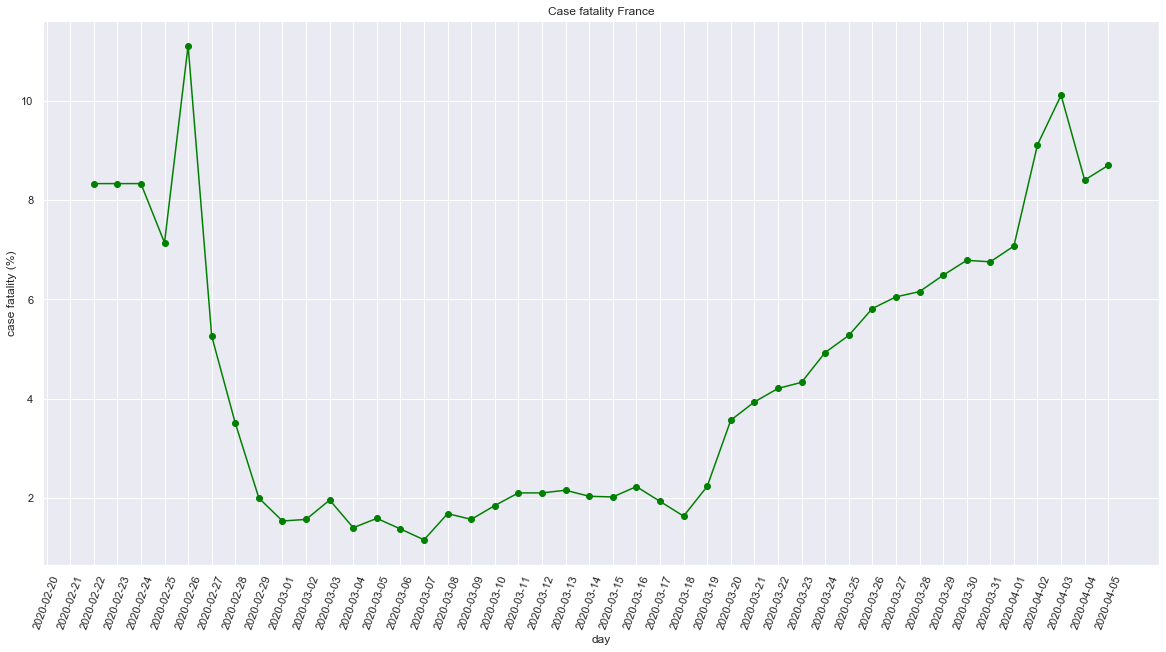

In [49]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Case fatality France")
ax.set_xlabel("day")
ax.set_ylabel("case fatality (%)");
ax.set_xticks(cf_fr.index)
ax.set_xticklabels(cf_fr.index[1:].format('%Y-%m-%d'), rotation=70)
plt.plot(cf_fr['2020-02-22':], color='green', marker='o')

***
## Spain

In [50]:
population_es = population[population['country_code'] == 'ES']['total'].values[0]
print("Spain's population (2019) = %d"%population_es)

Spain's population (2019) = 46937060


In [51]:
beds_es = beds[beds['country_code'] == 'ES']['2017'].values[0]
print("Spain's public and private health care facilities, available beds in 2017 = %d"%beds_es)

Spain's public and private health care facilities, available beds in 2017 = 138511


In [52]:
people_per_bed_es =  population_es / beds_es 
print("Number of persons per bed = %.0f"%people_per_bed_es)

Number of persons per bed = 339


### Cumulative confirmed infections
The number of infected individuals each day is the sum of all the confirmed infected individuals from the beginning up to that day.

In [53]:
confirmed_dataset_es = confirmed_dataset[confirmed_dataset['Country/Region'] == 'Spain'] 
confirmed_dataset_values_es = [confirmed for confirmed in confirmed_dataset_es.values[0][start_date_index:]] 
confirmed_infections_es = pd.Series(confirmed_dataset_values_es, index=dates_index)
confirmed_infections_es['2020-03-15':] 

2020-03-15      7798
2020-03-16      9942
2020-03-17     11748
2020-03-18     13910
2020-03-19     17963
2020-03-20     20410
2020-03-21     25374
2020-03-22     28768
2020-03-23     35136
2020-03-24     39885
2020-03-25     49515
2020-03-26     57786
2020-03-27     65719
2020-03-28     73235
2020-03-29     80110
2020-03-30     87956
2020-03-31     95923
2020-04-01    104118
2020-04-02    112065
2020-04-03    119199
2020-04-04    126168
2020-04-05    131646
dtype: int64

### Confirmed infections per day
The confirmed infections per day are computed from the cumulative confirmed infections by computing the difference between two consecutive days.

In [54]:
confirmed_per_day_array_es = [confirmed_infections_es[d++1] - confirmed_infections_es[d] for d in range(dates_index.size - 1)]
confirmed_per_day_es = pd.Series(confirmed_per_day_array_es, index=dates_index[1:])
confirmed_per_day_es['2020-03-15':]

2020-03-15    1407
2020-03-16    2144
2020-03-17    1806
2020-03-18    2162
2020-03-19    4053
2020-03-20    2447
2020-03-21    4964
2020-03-22    3394
2020-03-23    6368
2020-03-24    4749
2020-03-25    9630
2020-03-26    8271
2020-03-27    7933
2020-03-28    7516
2020-03-29    6875
2020-03-30    7846
2020-03-31    7967
2020-04-01    8195
2020-04-02    7947
2020-04-03    7134
2020-04-04    6969
2020-04-05    5478
dtype: int64

<BarContainer object of 64 artists>

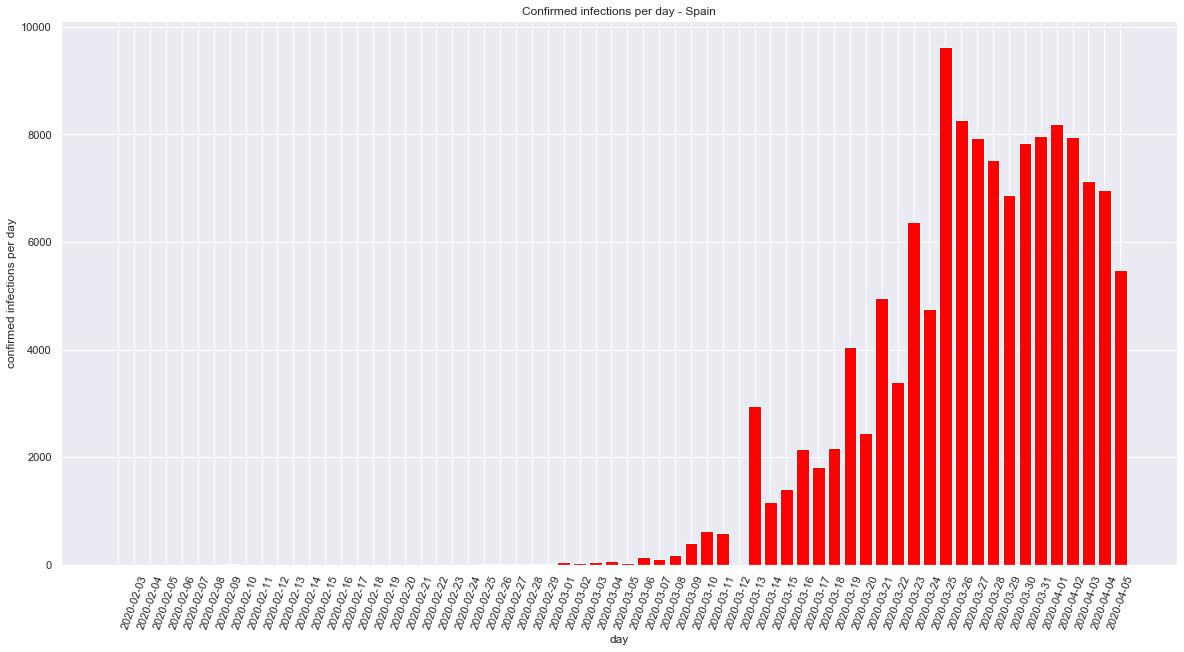

In [55]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Confirmed infections per day - Spain")
ax.set_xlabel("day")
ax.set_ylabel("confirmed infections per day");
ax.set_xticks(confirmed_per_day_es.index)
ax.set_xticklabels(confirmed_per_day_es.index[1:].format('%Y-%m-%d'), rotation=70)
plt.bar(dates_array[1:], confirmed_per_day_array_es, color='red')

### Cumulative deaths
The number of deaths each day is the sum of the deaths from the beginning up to that day.

In [56]:
deaths_dataset_es = deaths_dataset[deaths_dataset['Country/Region'] == 'Spain']
deaths_dataset_values_es = [death for death in deaths_dataset_es.values[0][start_date_index:]]
deaths_es = pd.Series(deaths_dataset_values_es, index=dates_index)
deaths_es['2020-03-15':]

2020-03-15      289
2020-03-16      342
2020-03-17      533
2020-03-18      623
2020-03-19      830
2020-03-20     1043
2020-03-21     1375
2020-03-22     1772
2020-03-23     2311
2020-03-24     2808
2020-03-25     3647
2020-03-26     4365
2020-03-27     5138
2020-03-28     5982
2020-03-29     6803
2020-03-30     7716
2020-03-31     8464
2020-04-01     9387
2020-04-02    10348
2020-04-03    11198
2020-04-04    11947
2020-04-05    12641
dtype: int64

### Deaths per day
The deaths per day are computed from the cumulative deaths by computing the difference between two consecutive days.

In [57]:
deaths_per_day_array_es = [deaths_es[d++1] - deaths_es[d] for d in range(dates_index.size - 1)]
deaths_per_day_es = pd.Series(deaths_per_day_array_es, index=dates_index[1:])
deaths_per_day_es['2020-03-15':]

2020-03-15     94
2020-03-16     53
2020-03-17    191
2020-03-18     90
2020-03-19    207
2020-03-20    213
2020-03-21    332
2020-03-22    397
2020-03-23    539
2020-03-24    497
2020-03-25    839
2020-03-26    718
2020-03-27    773
2020-03-28    844
2020-03-29    821
2020-03-30    913
2020-03-31    748
2020-04-01    923
2020-04-02    961
2020-04-03    850
2020-04-04    749
2020-04-05    694
dtype: int64

<BarContainer object of 64 artists>

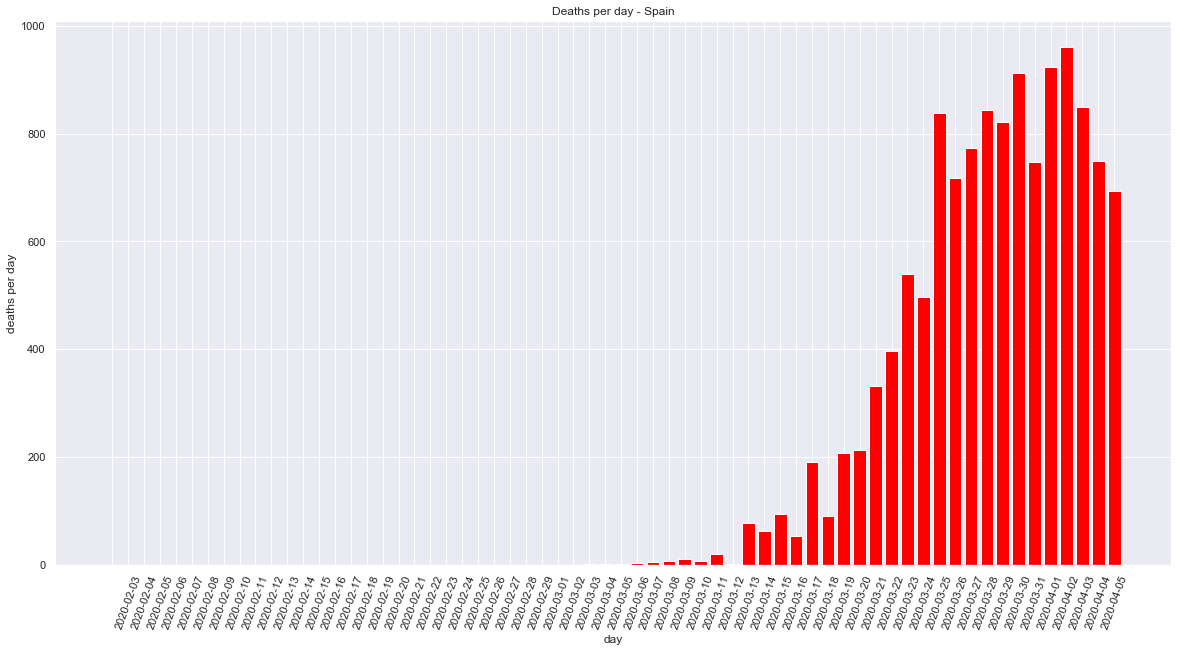

In [58]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Deaths per day - Spain")
ax.set_xlabel("day")
ax.set_ylabel("deaths per day");
ax.set_xticks(deaths_per_day_es.index)
ax.set_xticklabels(deaths_per_day_es.index[1:].format('%Y-%m-%d'), rotation=70)
plt.bar(dates_array[1:], deaths_per_day_array_es, color='red')

### Cumulative confirmed infections doubling time
Number of days for the cumulative confirmed infections to double

In [59]:
doubling_time_es = doubling_time(confirmed_infections_es)[last_day]
summary['Doubling Time']['Spain'] = doubling_time(confirmed_infections_es)[last_day]
print("Spain's cumulative infections doubling time = %.0d days"%doubling_time_es)

Spain's cumulative infections doubling time = 9 days


### Cumulative incidence

In [60]:
cumulative_incidence_es = (confirmed_infections_es[confirmed_infections_es.size - 1] / population_es) * 100000
summary['Incidence']['Spain'] = round((confirmed_infections_es[confirmed_infections_es.size - 1] / population_es) * 100000)
print("Spain's cumulative incidence = %.0f per 100.000 persons"%cumulative_incidence_es)

Spain's cumulative incidence = 280 per 100.000 persons


### Case fatality

In [61]:
last_infections_es = confirmed_infections_es[confirmed_infections_es.size - 1]
last_deaths_es = deaths_es[deaths_es.size - 1]
last_case_fatality_es = (last_deaths_es / last_infections_es) * 100 
summary['Confirmed Infections']['Spain'] = confirmed_infections_es[confirmed_infections_es.size - 1]
summary['Deaths']['Spain'] = deaths_es[deaths_es.size - 1]
summary['Case Fatality']['Spain'] = round((deaths_es[deaths_es.size - 1] / confirmed_infections_es[confirmed_infections_es.size - 1]) * 100,1)
print("Last report day: {0:4s} \ndeaths: {1:5d}; cumulative confirmed infections: {2:5d}; case fatality {3:5.2f} %".format(last_day, last_deaths_es, last_infections_es, last_case_fatality_es))  

Last report day: 2020-04-05 
deaths: 12641; cumulative confirmed infections: 131646; case fatality  9.60 %


In [62]:
cf_array_es = [(deaths_es[d] / confirmed_infections_es[d]) * 100 for d in range(dates_index.size)]
cf_es = pd.Series(cf_array_es, index=dates_index)

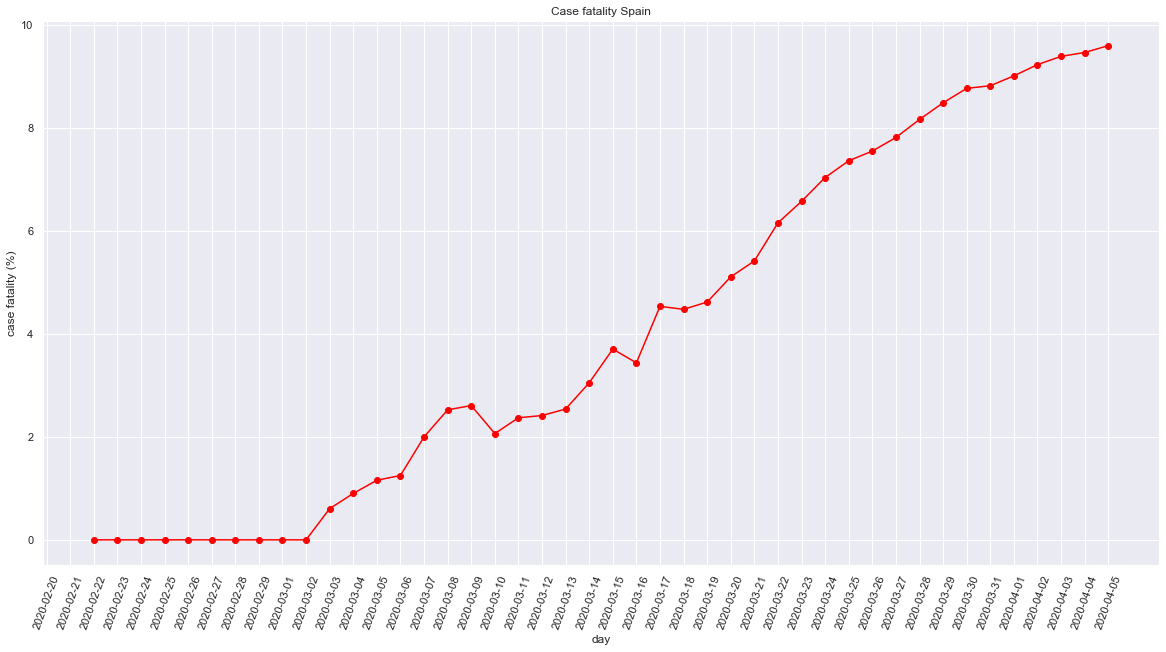

In [63]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Case fatality Spain")
ax.set_xlabel("day")
ax.set_ylabel("case fatality (%)");
ax.set_xticks(cf_es.index)
ax.set_xticklabels(cf_es.index[1:].format('%Y-%m-%d'), rotation=70)
plt.plot(cf_es['2020-02-22':], color='red', marker='o')

***
## Comparisons
Merged graphs for Italy, Germany, France and Spain

### Cumulative confirmed infections

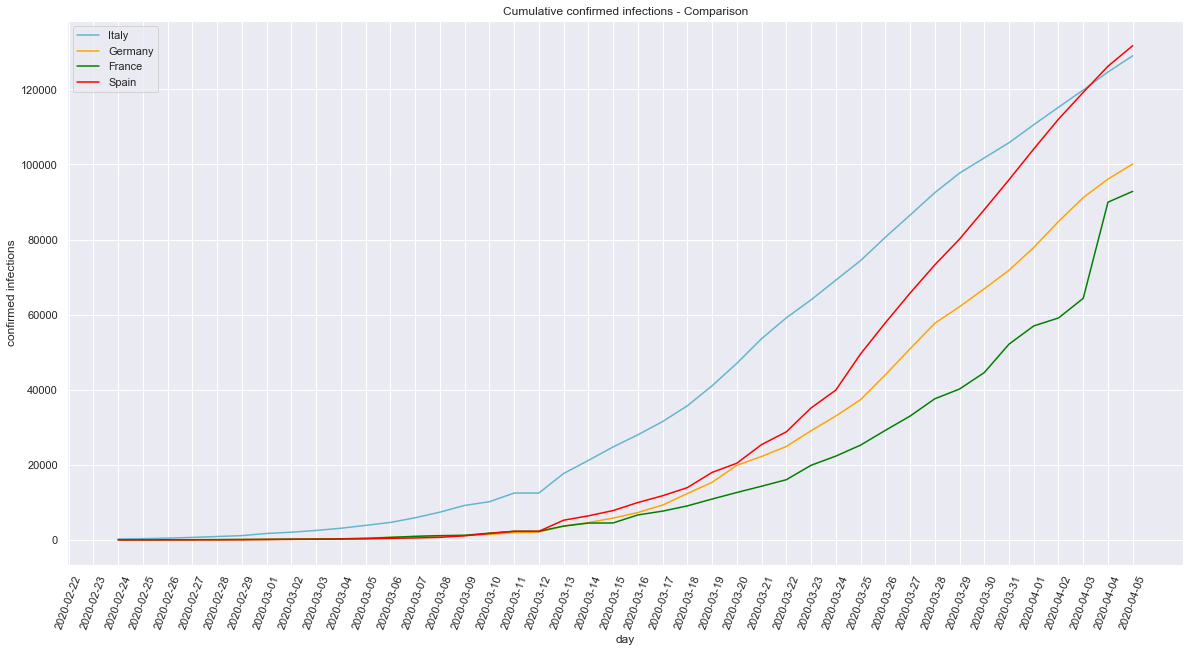

In [64]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Cumulative confirmed infections - Comparison")
ax.set_xlabel("day")
ax.set_ylabel("confirmed infections");
ax.set_xticks(confirmed_infections_it.index)
ax.set_xticklabels(confirmed_infections_it.index[1:].format('%Y-%m-%d'), rotation=70)
pi_it, = plt.plot(confirmed_infections_it['2020-02-24':], label='Italy', color='c')
pi_de, = plt.plot(confirmed_infections_de['2020-02-24':], label='Germany', color='orange')
pi_fr, = plt.plot(confirmed_infections_fr['2020-02-24':], label='France', color='green')
pi_es, = plt.plot(confirmed_infections_es['2020-02-24':], label='Spain', color='red')
plt.legend(handles=[pi_it, pi_de, pi_fr, pi_es])

### Doubling Time
Doubling time for the confirmed infections

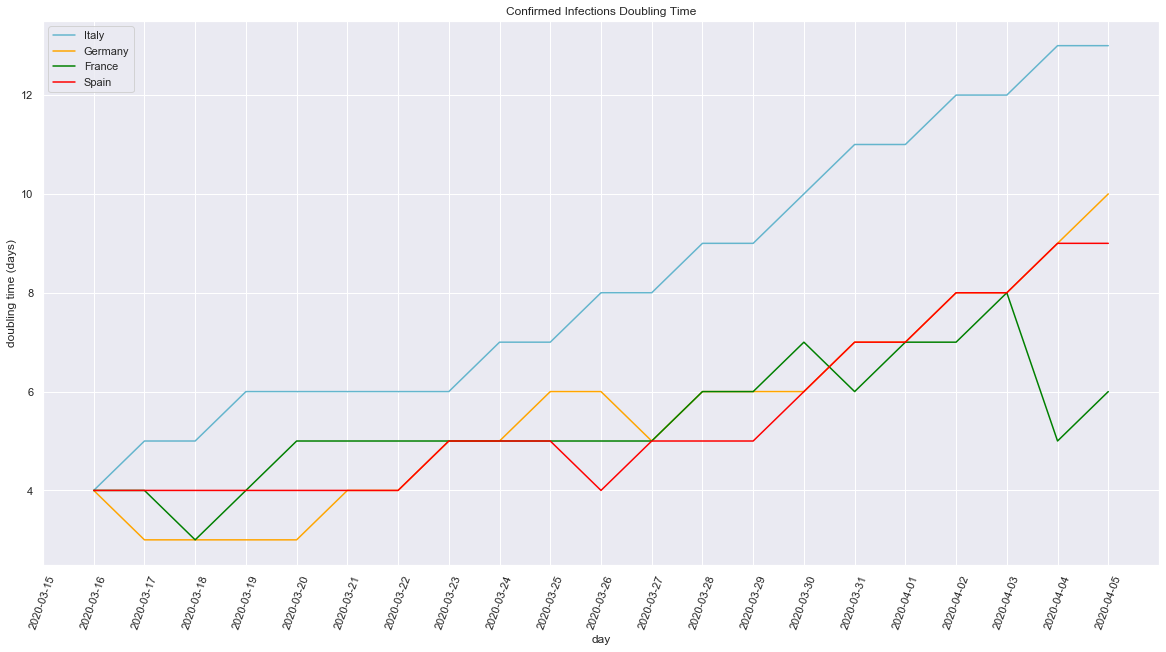

In [65]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Confirmed Infections Doubling Time")
ax.set_xlabel("day")
ax.set_ylabel("doubling time (days)");
ax.set_xticks(confirmed_infections_it.index)
ax.set_xticklabels(confirmed_infections_it.index[1:].format('%Y-%m-%d'), rotation=70)
pi_it, = plt.plot(doubling_time(confirmed_infections_it)['2020-03-16':], label='Italy', color='c')
pi_de, = plt.plot(doubling_time(confirmed_infections_de)['2020-03-16':], label='Germany', color='orange')
pi_fr, = plt.plot(doubling_time(confirmed_infections_fr)['2020-03-16':], label='France', color='green')
pi_es, = plt.plot(doubling_time(confirmed_infections_es)['2020-03-16':], label='Spain', color='red')
plt.legend(handles=[pi_it, pi_de, pi_fr, pi_es])
plt.savefig('doubling-time-2020-03-30.png')

### Cumulative deaths

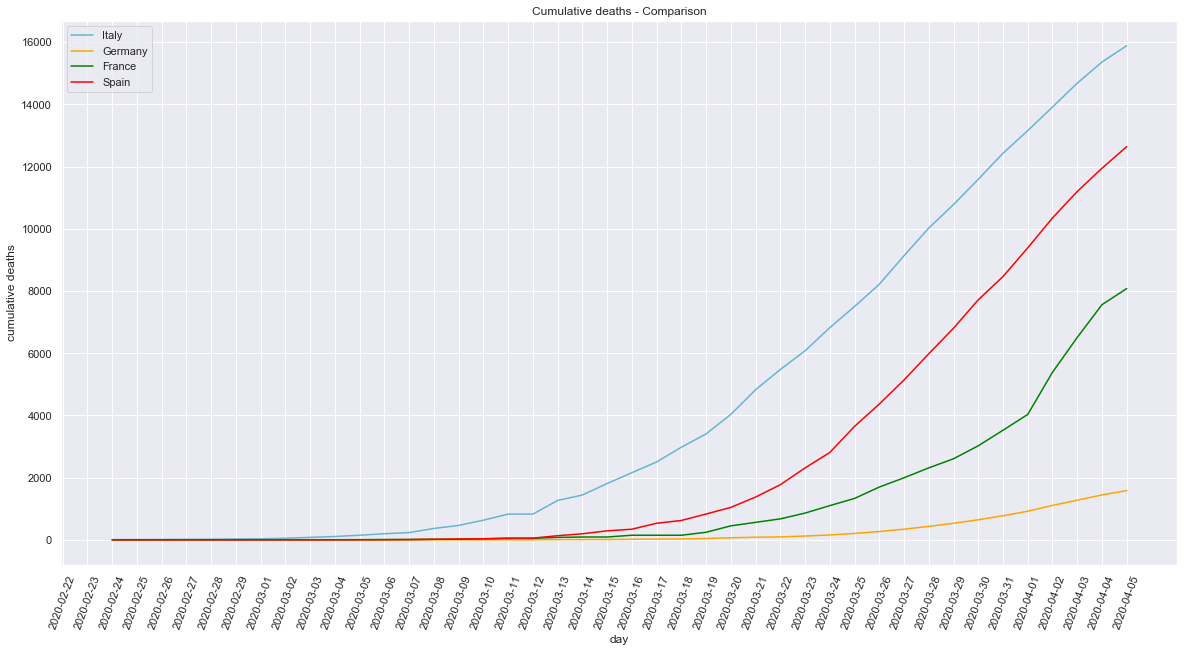

In [66]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Cumulative deaths - Comparison")
ax.set_xlabel("day")
ax.set_ylabel("cumulative deaths");
ax.set_xticks(deaths_it.index)
ax.set_xticklabels(deaths_it.index[1:].format('%Y-%m-%d'), rotation=70)
pd_it, = plt.plot(deaths_it['2020-02-24':], label='Italy', color='c')
pd_de, = plt.plot(deaths_de['2020-02-24':], label='Germany', color='orange')
pd_fr, = plt.plot(deaths_fr['2020-02-24':], label='France', color='green')
pd_es, = plt.plot(deaths_es['2020-02-24':], label='Spain', color='red')
plt.legend(handles=[pd_it, pd_de, pd_fr, pd_es])

### Confirmed infections per day

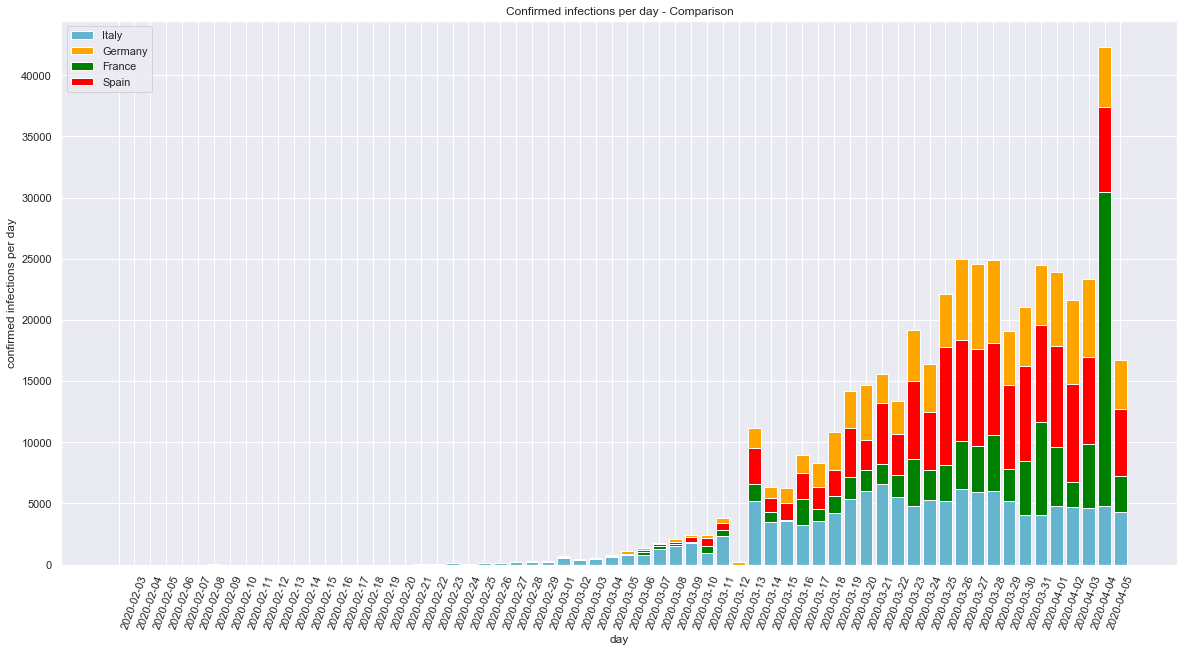

In [67]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Confirmed infections per day - Comparison")
ax.set_xlabel("day")
ax.set_ylabel('confirmed infections per day')
ax.set_xticks(confirmed_per_day_it.index)
ax.set_xticklabels(confirmed_per_day_it.index[1:].format('%Y-%m-%d'), rotation=70)
pi_it = plt.bar(dates_array[1:], confirmed_per_day_array_it, color='c')
pi_fr = plt.bar(dates_array[1:], confirmed_per_day_array_fr, bottom=confirmed_per_day_array_it, color='green')
len_array = len(confirmed_per_day_array_it)
bar_base = [confirmed_per_day_array_it[d] + confirmed_per_day_array_fr[d] for d in range(len_array)]
pi_es = plt.bar(dates_array[1:], confirmed_per_day_array_es, bottom = bar_base, color='red')
bar_base = [bar_base[d] + confirmed_per_day_array_es[d] for d in range(len_array)] # bottom update
pi_de = plt.bar(dates_array[1:], confirmed_per_day_array_de, bottom = bar_base, color='orange')
plt.legend((pi_it, pi_de, pi_fr, pi_es), ['Italy', 'Germany', 'France', 'Spain'], loc='upper left')
#plt.savefig('deaths-per-day.png')

### Deaths per day

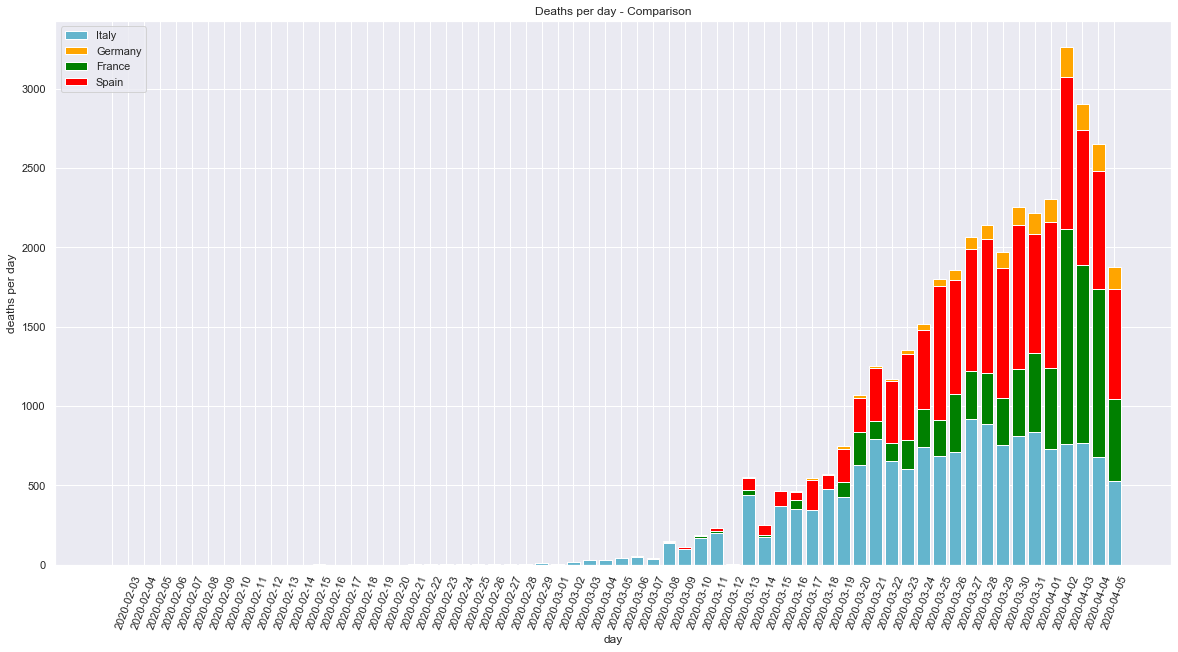

In [68]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Deaths per day - Comparison")
ax.set_xlabel("day")
ax.set_ylabel('deaths per day')
ax.set_xticks(confirmed_per_day_it.index)
ax.set_xticklabels(confirmed_per_day_it.index[1:].format('%Y-%m-%d'), rotation=70)
pi = plt.bar(dates_array[1:], deaths_per_day_array_it, color='c')
pf = plt.bar(dates_array[1:], deaths_per_day_array_fr, bottom = deaths_per_day_array_it, color='green')
len_array = len(deaths_per_day_array_it)
bar_base = [deaths_per_day_array_it[d] + deaths_per_day_array_fr[d] for d in range(len_array)]
ps = plt.bar(dates_array[1:], deaths_per_day_array_es, bottom = bar_base, color='red')
bar_base = [bar_base[d] + deaths_per_day_array_es[d] for d in range(len_array)]
pg = plt.bar(dates_array[1:], deaths_per_day_array_de, bottom = bar_base, color='orange')
plt.legend((pi[0], pg[0], pf[0], ps[0]), ['Italy', 'Germany', 'France', 'Spain'], loc='upper left')
plt.savefig('deaths-per-day-2020-03-22.png')

### Case fatality

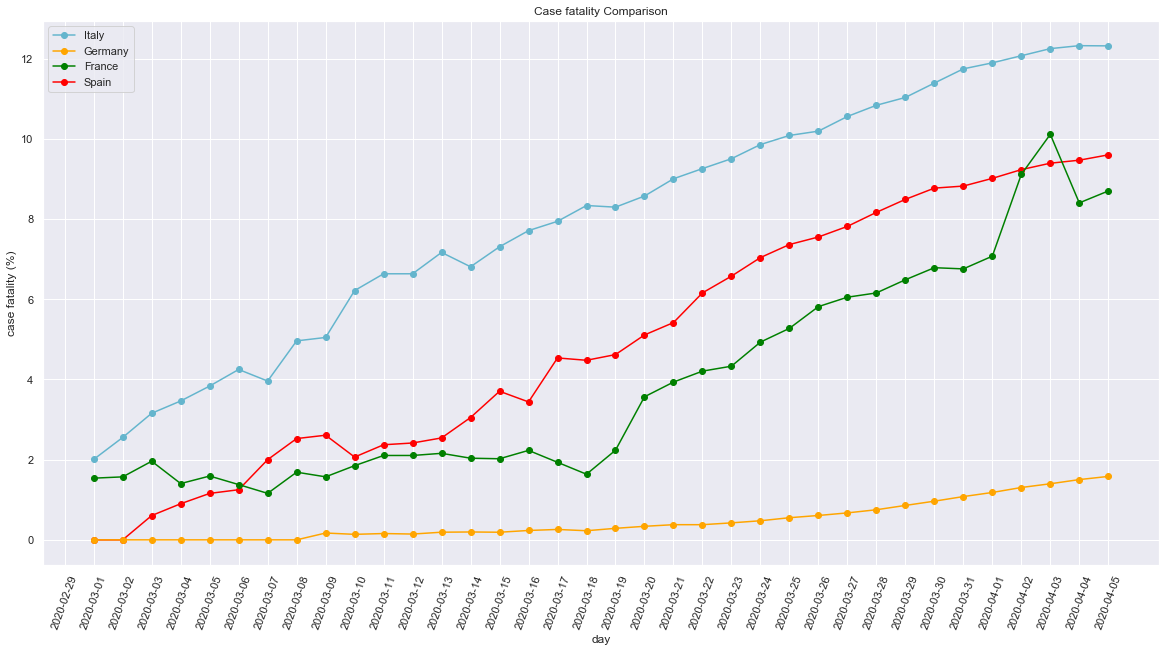

In [69]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Case fatality Comparison")
ax.set_xlabel("day")
ax.set_ylabel("case fatality (%)");
ax.set_xticks(cf_it.index)
ax.set_xticklabels(cf_it.index[1:].format('%Y-%m-%d'), rotation=70)
pcf_it = plt.plot(cf_it['2020-03-01':], color='c', marker='o')
pcf_es = plt.plot(cf_es['2020-03-01':], color='red', marker='o')
pcf_fr = plt.plot(cf_fr['2020-03-01':], color='green', marker='o')
pcf_de = plt.plot(cf_de['2020-03-01':], color='orange', marker='o')
plt.legend((pcf_it[0], pcf_de[0], pcf_fr[0], pcf_es[0]), ['Italy', 'Germany', 'France', 'Spain'])
plt.savefig('case_fatalities-2020-03-22.png')

***
## Summary

In [70]:
print("Last report day: ", last_day)  

Last report day:  2020-04-05


In [71]:
summary

,Confirmed Infections,Doubling Time,Incidence,Deaths,Case Fatality
Italy,128948,13,214,15887,12.3
Germany,100123,10,121,1584,1.6
France,92839,6,139,8078,8.7
Spain,131646,9,280,12641,9.6


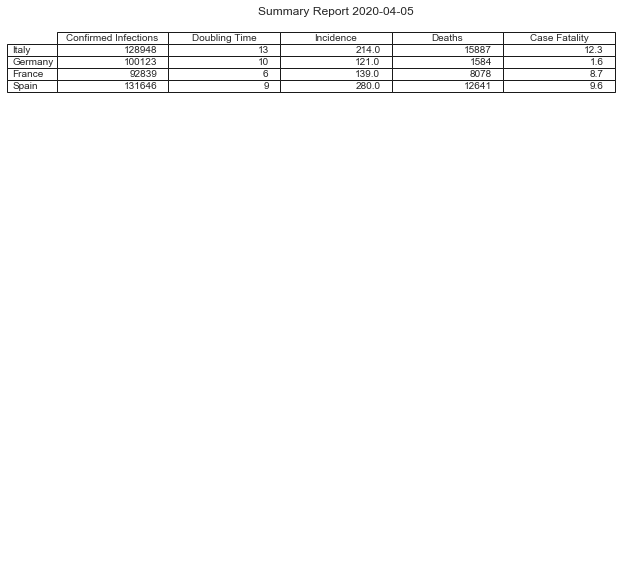

In [72]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(frame_on=False)
ax.axis('off')
ax.table(cellText=summary.values, rowLabels=summary.index, colLabels=summary.columns, loc='upper center')
plt.title('Summary Report ' + last_day)
plt.savefig('summary.png')